### Test the trained model on data distribution

In [1]:
import random
import numpy as np
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch
import learn2learn as l2l
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
# The corase reconstruction is the rss of the zerofilled multi-coil kspaces
# after inverse FT.
from functions.data.transforms import UnetDataTransform_norm, normalize
# Import a torch.utils.data.Dataset class that takes a list of data examples, a path to those examples
# a data transform and outputs a torch dataset.
from functions.data.mri_dataset import SliceDataset
# Unet architecture as nn.Module
from functions.models.unet import Unet
# Function that returns a MaskFunc object either for generatig random or equispaced masks
from functions.data.subsample import create_mask_for_mask_type
# Implementation of SSIMLoss
from functions.training.losses import SSIMLoss
from functions.helper import evaluate_loss_dataloader

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Set seed
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Testing Metrics

Load model

In [14]:
checkpoint_path = "/cheng/metaMRI/metaMRI/save/E8knee_standard(NMSE-CA)_P8_T1x200_70epoch/E8knee_standard(NMSE-CA)_P8_T1x200_70epoch_E33_best.pth"
# "/cheng/metaMRI/metaMRI/save/E10.2_standard(NMSE-lr1e-3CA4)_T8x200_120epoch/E10.2_standard(NMSE-lr1e-3CA4)_T8x200_120epoch_E87_best.pth"
# "/cheng/metaMRI/metaMRI/save/E10.2_maml(NMSE-lre-3)_T8x200_250epoch/E10.2_maml(NMSE-lre-3)_T8x200_250epoch_E238_best.pth"
model = Unet(in_chans=1, out_chans=1, chans=32, num_pool_layers=4, drop_prob=0.0)
model.load_state_dict(torch.load(checkpoint_path))
model = model.to(device).eval()

Load data

In [15]:
path_test = '/cheng/metaMRI/metaMRI/data_dict/Task_8knee/P/knee_test_PDFS_Skyra_15-22.yaml'
# '/cheng/metaMRI/metaMRI/data_dict/Task_8knee/P/knee_test_PD_Aera_2-9.yaml'
# '/cheng/metaMRI/metaMRI/data_dict/Task_8knee/P/knee_test_PD_Aera_15-22.yaml'
# '/cheng/metaMRI/metaMRI/data_dict/Task_8knee/P/knee_test_PD_Biograph_15-22.yaml'
# '/cheng/metaMRI/metaMRI/data_dict/Task_8knee/P/knee_test_PD_Skyra_15-22.yaml'
# '/cheng/metaMRI/metaMRI/data_dict/Task_8knee/P/knee_test_PDFS_Aera_2-9.yaml'
# '/cheng/metaMRI/metaMRI/data_dict/Task_8knee/P/knee_test_PDFS_Aera_15-22.yaml'
# '/cheng/metaMRI/metaMRI/data_dict/Task_8knee/P/knee_test_PDFS_Biograph_15-22.yaml'
# '/cheng/metaMRI/metaMRI/data_dict/Task_8knee/P/knee_test_PDFS_Skyra_15-22.yaml'
# mask function and data transform
mask_function = create_mask_for_mask_type(mask_type_str = 'random', self_sup = False, 
                    center_fraction = 0.08, acceleration = 4.0, acceleration_total = 3.0)
data_transform_test = UnetDataTransform_norm('multicoil', mask_func = mask_function, use_seed=True, mode='adapt')
# dataset: num_sample_subset x 3
testset = SliceDataset(dataset = path_test, path_to_dataset='', path_to_sensmaps=None, provide_senmaps=False, 
                      challenge="multicoil", transform=data_transform_test, use_dataset_cache=True)
test_dataloader = torch.utils.data.DataLoader(dataset = testset, batch_size = 1, shuffle = False, 
                                generator = torch.Generator().manual_seed(1), pin_memory = True)


Evaluate

In [16]:
test_L1, test_NMSE, test_PSNR, test_SSIM = evaluate_loss_dataloader(model, test_dataloader)
print('Testing L1: ', test_L1)
print('Testing NMSE: ', test_NMSE)
print('Testing PSNR: ', test_PSNR)
print('Testing SSIM: ', test_SSIM)

Testing L1:  0.08953132458031178
Testing NMSE:  0.011432167990133166
Testing PSNR:  33.07640003204346
Testing SSIM:  0.815692150592804


### Inference

Renew the data

In [8]:
iterator = iter(test_dataloader)

In [13]:
batch = next(iterator)
input_image, target_image, mean, std, fname, slice_num = batch
print(fname)
print(slice_num)
input_image = input_image.to(device)
target_image = target_image.to(device)
std = std.to(device)
mean = mean.to(device)

output = model(input_image)
output = output * std + mean

# SSIM
ssim_fct = SSIMLoss()
ssim = 1 - ssim_fct(output, target_image, data_range = target_image.max().unsqueeze(0)).item()
ssim

['file_brain_AXT2_202_2020054']
tensor([5])


0.839997410774231

Plot

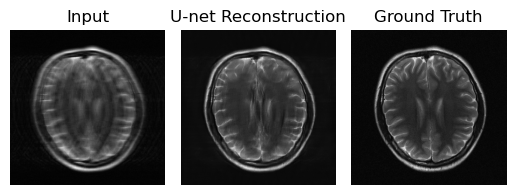

In [14]:
fig, axes = plt.subplots(1, 3)

axes[0].imshow(input_image.squeeze(0).squeeze(0).cpu().detach().numpy(),cmap='gray')
axes[0].set_title('Input')
axes[0].axis('off')

axes[1].imshow(output.squeeze(0).squeeze(0).cpu().detach().numpy(),cmap='gray')
axes[1].set_title('\Reconstruction')
axes[1].axis('off')

axes[2].imshow(target_image.squeeze(0).squeeze(0).cpu().detach().numpy(),cmap='gray')
axes[2].set_title('Ground Truth')
axes[2].axis('off')

plt.subplots_adjust(wspace=0.1)
plt.show()